# ***IMPORT LIBARY*** 

In [1]:
import torch
import torch.nn as nn

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tqdm import tqdm
from torchvision import transforms, models
from PIL import Image
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# ***READ TRAIN, TEST FILE***

In [2]:
data_root_path = '/kaggle/input/ai-vs-human-generated-dataset'

train_df = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/train.csv')
train_df.head(10)

,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1
5,5,train_data/25ea852f30594bc5915eb929682af429.jpg,0
6,6,train_data/e67085fb6d814cbabe08f978c738f3f7.jpg,1
7,7,train_data/041c36d9269146cdb88e7526e3b91651.jpg,0
8,8,train_data/4aea3b876247467c8d3713d4920148ab.jpg,1
9,9,train_data/09708379751e44d0bc908d8652d0db3e.jpg,0


In [3]:
len(train_df)

79950

In [4]:
test_df = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/test.csv')
test_df.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [5]:
len(test_df)

5540

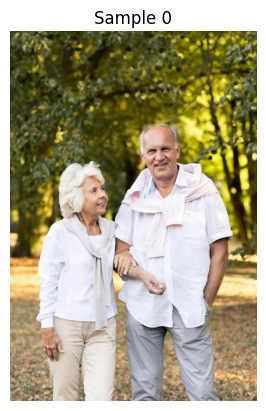

In [6]:
image_0_url = 'train_data/041be3153810433ab146bc97d5af505c.jpg'
read_image_0 = cv2.imread(os.path.join(data_root_path,image_0_url))
read_image_0 = cv2.cvtColor(read_image_0,cv2.COLOR_BGR2RGB)
plt.imshow(read_image_0)
plt.title('Sample 0')
plt.axis('off')
plt.show()

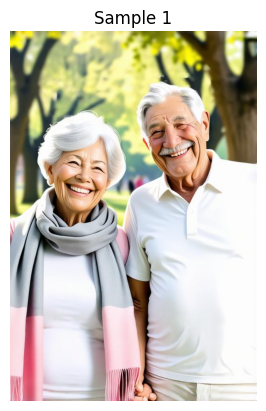

In [7]:
image_1_url = 'train_data/a6dcb93f596a43249135678dfcfc17ea.jpg'
read_image_1 = cv2.imread(os.path.join(data_root_path,image_1_url))
read_image_1 = cv2.cvtColor(read_image_1,cv2.COLOR_BGR2RGB)
plt.imshow(read_image_1)
plt.title('Sample 1')
plt.axis('off')
plt.show()

# ***SPLIT TRAIN, VALIDATION, TEST***

In [8]:
train_df = train_df.drop(columns = ['Unnamed: 0'])

In [9]:
train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(data_root_path, x))

In [10]:
train_df.head()

,file_name,label
0,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
1,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
2,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
3,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
4,/kaggle/input/ai-vs-human-generated-dataset/tr...,1


In [11]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state = 42)
len(train_df), len(val_df)

(63960, 15990)

# ***PREPARE DATA*** 

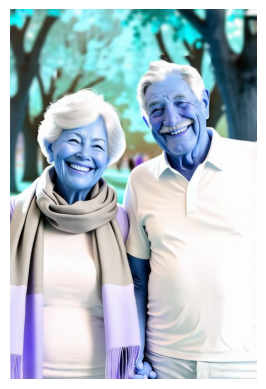

In [12]:
read_data = cv2.imread(train_df['file_name'][0])
plt.imshow(read_data)
plt.axis('off')
plt.show()

In [13]:
class ImageDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        self.df = pd.DataFrame(df)  
        self.transform = transform
        self.is_test = is_test  

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["file_name"]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.is_test:
            return img  
        else:
            label = self.df.iloc[idx]["label"]
            return img, label

# ***DATA AGUMENTATION, PREPROCESSING***

In [14]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
train_dataset = ImageDataset(df=train_df, transform=train_transform, is_test=False)
val_dataset = ImageDataset(df=val_df, transform=val_transform, is_test=False)

# ***DATA LOADER***

In [16]:
batch_size = 64

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [18]:
batch_images, batch_labels = next(iter(train_loader))
print(f"Batch shape: {batch_images.shape}, Labels shape: {batch_labels.shape}")

Batch shape: torch.Size([64, 3, 224, 224]), Labels shape: torch.Size([64])


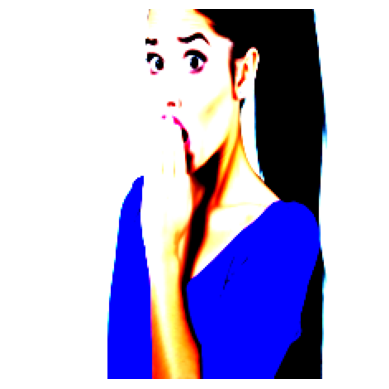

In [19]:
test_img = batch_images[1].permute(1,2,0)
plt.imshow(test_img)
plt.axis('off')
plt.show()

# ***PREPARE MODEL***

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# ***ConvNext***

In [21]:
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
num_classes = 2
model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 213MB/s] 


In [22]:
for param in model.features.parameters():
    param.requires_grad = False

In [23]:
lr = 1e-3
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=lr)
num_epochs=10

In [24]:
train_losses = []
train_accuracy = []

val_losses = []
val_accuracy = []

for epoch in range(num_epochs):
# Training 
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).long()  

        outputs = model(images) 
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    train_losses.append(train_avg_loss)
    train_accuracy.append(train_acc)
    
#Valiadation
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    val_pred_classes, val_labels_list = [], []

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device).long()  
    
            outputs = model(images) 
            loss = criterion(outputs, labels)
    
            val_running_loss += loss.item()
    
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            val_pred_classes.extend(predicted.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())
    
        val_avg_loss = val_running_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

    val_losses.append(val_avg_loss)
    val_accuracy.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] | Train_Loss: {train_avg_loss:.4f} | Train_Accuracy: {train_acc:.4f} | Val_Loss: {val_avg_loss:.4f} | Val_Accuracy: {val_acc:.4f}')

Epoch [1/10] | Train_Loss: 0.1862 | Train_Accuracy: 92.9987 | Val_Loss: 0.1363 | Val_Accuracy: 95.0469
Epoch [2/10] | Train_Loss: 0.1313 | Train_Accuracy: 95.1407 | Val_Loss: 0.1354 | Val_Accuracy: 94.9656
Epoch [3/10] | Train_Loss: 0.1265 | Train_Accuracy: 95.3080 | Val_Loss: 0.1360 | Val_Accuracy: 94.9343
Epoch [4/10] | Train_Loss: 0.1231 | Train_Accuracy: 95.3612 | Val_Loss: 0.1237 | Val_Accuracy: 95.4346
Epoch [5/10] | Train_Loss: 0.1251 | Train_Accuracy: 95.2752 | Val_Loss: 0.1467 | Val_Accuracy: 94.4841
Epoch [6/10] | Train_Loss: 0.1247 | Train_Accuracy: 95.2986 | Val_Loss: 0.1261 | Val_Accuracy: 95.2971
Epoch [7/10] | Train_Loss: 0.1212 | Train_Accuracy: 95.3737 | Val_Loss: 0.1274 | Val_Accuracy: 95.2595
Epoch [8/10] | Train_Loss: 0.1228 | Train_Accuracy: 95.2955 | Val_Loss: 0.1431 | Val_Accuracy: 94.6091
Epoch [9/10] | Train_Loss: 0.1229 | Train_Accuracy: 95.3111 | Val_Loss: 0.1395 | Val_Accuracy: 94.7905
Epoch [10/10] | Train_Loss: 0.1221 | Train_Accuracy: 95.3752 | Val_Loss: 

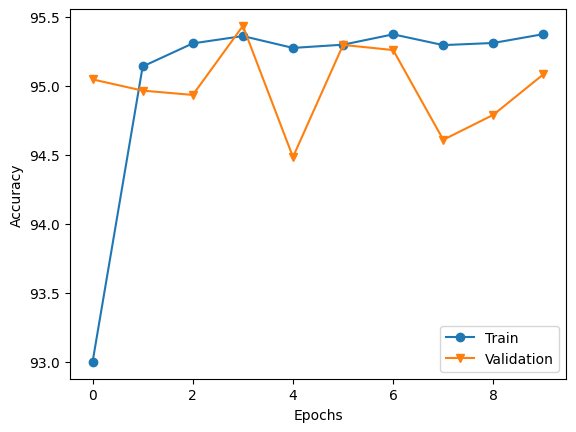

In [35]:
plt.plot(train_accuracy,marker = 'o')
plt.plot(val_accuracy,marker = 'v')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])
plt.show()

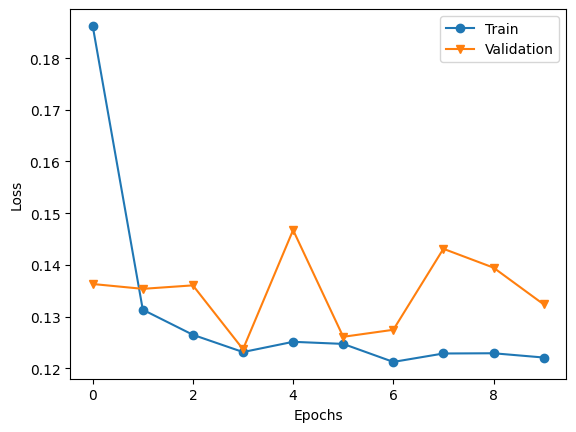

In [26]:
plt.plot(train_losses,marker = 'o')
plt.plot(val_losses,marker = 'v')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])
plt.show()

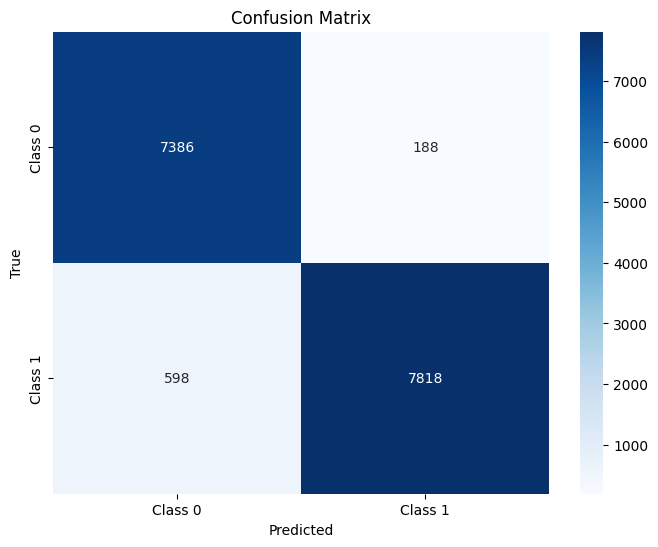

In [27]:
conf_matrix = confusion_matrix(val_pred_classes, val_labels_list)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

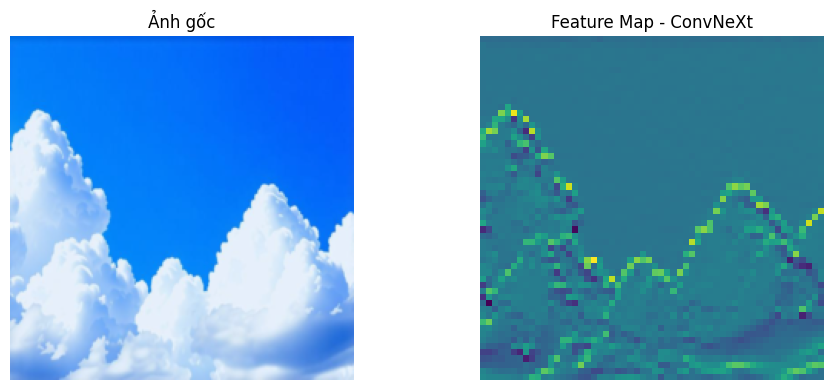

In [47]:
sample_img, _ = next(iter(val_loader))
sample_img = sample_img[0].unsqueeze(0).to(device)  # Chọn ảnh đầu tiên

def show_original_and_feature_map_convnext(model, image_tensor):
    model.eval()
    with torch.no_grad():
        features = model.features[0](image_tensor) 
        fmap = features[0, 0].cpu().numpy() 

    orig_img = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min())  # Chuẩn hóa

    # Hiển thị
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title("Ảnh gốc")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(fmap, cmap='viridis')
    plt.title("Feature Map - ConvNeXt")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

show_original_and_feature_map_convnext(model, sample_img)

# ***Vision Transformer***

In [28]:
from transformers import ViTForImageClassification


model_v2 = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=2  
)

model_v2 = model_v2.to(device)
for param in model_v2.vit.parameters():
    param.requires_grad = False

2025-05-25 15:37:59.048758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748187479.254430      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748187479.309075      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
lr = 1e-3
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model_v2.parameters(),lr=lr)
num_epochs=10

In [30]:
train_losses_v2 = []
train_accuracy_v2 = []

val_losses_v2 = []
val_accuracy_v2 = []

for epoch in range(num_epochs):
# Training 
    model_v2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).long()  

        outputs = model_v2(images) 
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    train_losses_v2.append(train_avg_loss)
    train_accuracy_v2.append(train_acc)
    
#Valiadation
    model_v2.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    val_pred_classes_v2, val_labels_list_v2 = [], []

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device).long()  
    
            outputs = model_v2(images) 
            loss = criterion(outputs.logits, labels)
    
            val_running_loss += loss.item()
    
            _, predicted = torch.max(outputs.logits, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            val_pred_classes_v2.extend(predicted.cpu().numpy())
            val_labels_list_v2.extend(labels.cpu().numpy())
    
        val_avg_loss = val_running_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

    val_losses_v2.append(val_avg_loss)
    val_accuracy_v2.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] | Train_Loss: {train_avg_loss:.4f} | Train_Accuracy: {train_acc:.4f} | Val_Loss: {val_avg_loss:.4f} | Val_Accuracy: {val_acc:.4f}')

Epoch [1/10] | Train_Loss: 0.3318 | Train_Accuracy: 87.6141 | Val_Loss: 0.2564 | Val_Accuracy: 90.4065
Epoch [2/10] | Train_Loss: 0.2308 | Train_Accuracy: 91.5181 | Val_Loss: 0.2218 | Val_Accuracy: 91.6510
Epoch [3/10] | Train_Loss: 0.2090 | Train_Accuracy: 92.1388 | Val_Loss: 0.2088 | Val_Accuracy: 92.0826
Epoch [4/10] | Train_Loss: 0.1975 | Train_Accuracy: 92.4859 | Val_Loss: 0.2044 | Val_Accuracy: 92.0575
Epoch [5/10] | Train_Loss: 0.1912 | Train_Accuracy: 92.7939 | Val_Loss: 0.1987 | Val_Accuracy: 92.3952
Epoch [6/10] | Train_Loss: 0.1881 | Train_Accuracy: 92.8158 | Val_Loss: 0.1934 | Val_Accuracy: 92.5266
Epoch [7/10] | Train_Loss: 0.1846 | Train_Accuracy: 92.9378 | Val_Loss: 0.1941 | Val_Accuracy: 92.5016
Epoch [8/10] | Train_Loss: 0.1825 | Train_Accuracy: 93.0019 | Val_Loss: 0.1916 | Val_Accuracy: 92.4265
Epoch [9/10] | Train_Loss: 0.1817 | Train_Accuracy: 92.9346 | Val_Loss: 0.1964 | Val_Accuracy: 92.2639
Epoch [10/10] | Train_Loss: 0.1799 | Train_Accuracy: 93.0816 | Val_Loss: 

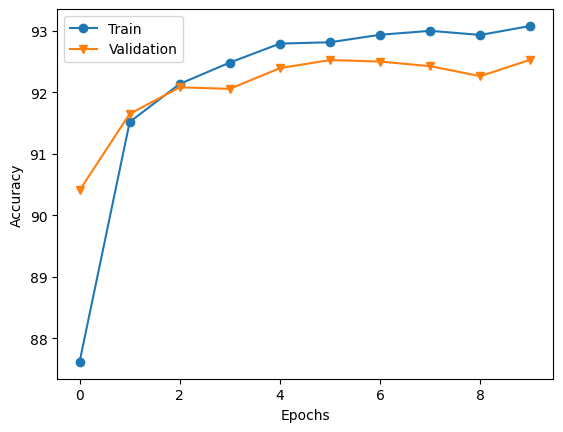

In [36]:
plt.plot(train_accuracy_v2,marker = 'o')
plt.plot(val_accuracy_v2,marker = 'v')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])
plt.show()

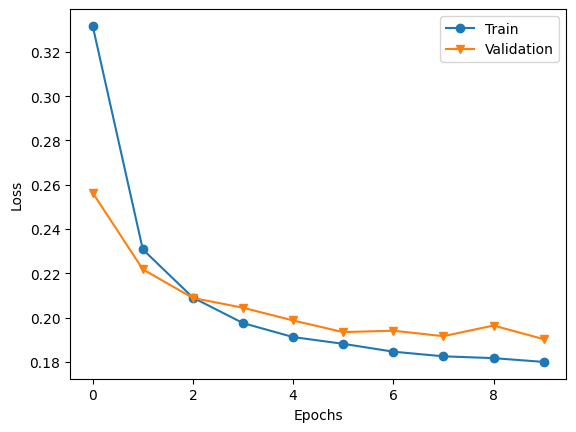

In [32]:
plt.plot(train_losses_v2,marker = 'o')
plt.plot(val_losses_v2,marker = 'v')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])
plt.show()

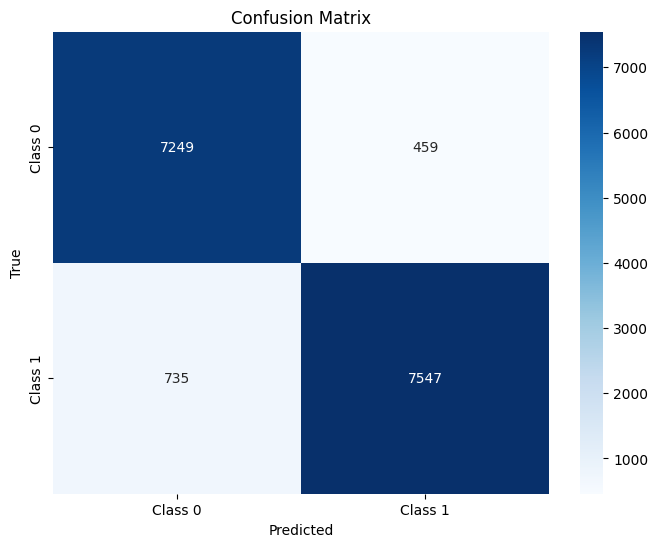

In [34]:
conf_matrix = confusion_matrix(val_pred_classes_v2, val_labels_list_v2)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [64]:
def show_attention_map_full_image(model, image_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor, output_attentions=True)
        attentions = outputs.attentions  
        
        last_layer_attn = attentions[-1]  
        avg_attn = last_layer_attn.mean(dim=1) 

        cls_attn = avg_attn[0, 0, 1:] 

        attn_map = cls_attn.reshape(14, 14).cpu().numpy()

        attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    # Chuẩn bị ảnh gốc để hiển thị
    orig_img = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min())

    # Resize attention map để trùng kích thước ảnh
    from scipy.ndimage import zoom
    attn_map_resized = zoom(attn_map, orig_img.shape[:2][0] / 14)

    # Hiển thị ảnh và bản đồ attention overlay
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title("Ảnh gốc")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(orig_img)
    plt.imshow(attn_map_resized, cmap='jet', alpha=0.5)  # Overlay attention
    plt.title("Attention Map")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

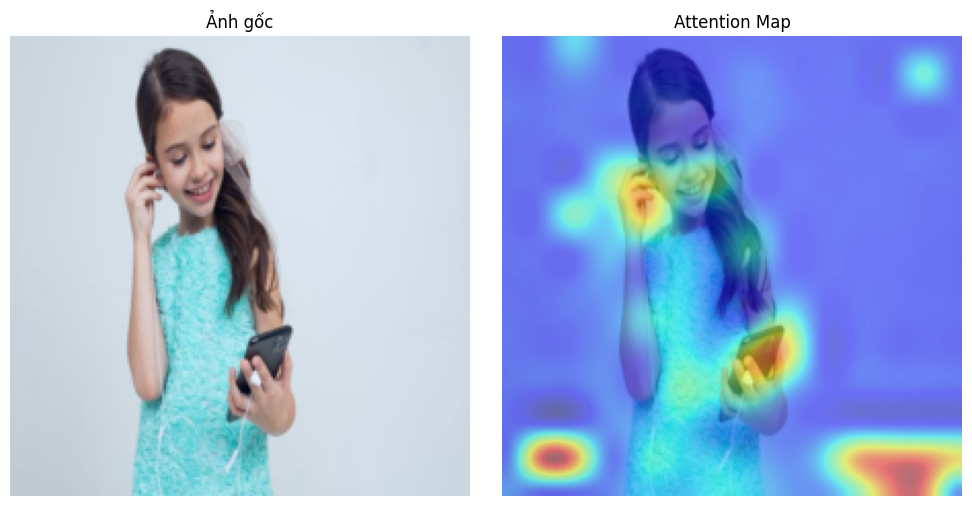

In [67]:
sample_img, _ = next(iter(val_loader))
sample_img = sample_img[1].unsqueeze(0).to(device)

show_attention_map_full_image(model_v2.to(device), sample_img)